In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import utils
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import r2_score, regression, precision_score, recall_score, accuracy_score, fbeta_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [35]:
FMA_TEST_HOLDOUT_PERCENT = 0.20
POPULARITY_THRESHOLD = 90
TOP_N_FEAT = 10
MIN_TRAIN_SONGS = 150

In [17]:
# combo_df = pd.read_csv("../data/combined_features.csv") 
tracks = pd.read_csv("../data/mod_tracks.csv")
features = pd.read_csv("../data/mod_features.csv")
echonest = pd.read_csv("../data/mod_echonest.csv")

In [36]:
new_feat = pd.read_csv("../data/new_feat_large.csv")

new_feat.index = new_feat.track_id
new_feat.drop(["track_id"], inplace=True, axis=1)

In [37]:
# For test data from Spotify
vanilla_test = pd.read_csv("../data/vanilla_test_new.csv")
test_features = ["duration", "acousticness","danceability","energy","instrumentalness","liveness","speechiness","tempo","valence"]
vanilla_test.index = vanilla_test["track_id"]

spotify_y = vanilla_test["track_popularity"].map(lambda x: 1 if x == "Popular" else 0)
spotify_genres = vanilla_test["genre_top"]

spotify_genres = spotify_genres.map(lambda x: "Hip-Hop" if x == "Hip Hop" else x)
vanilla_test = vanilla_test[test_features]

In [38]:
hand_crafted_test = pd.read_csv("../data/hand_crafted_test_new.csv")
hand_crafted_test.index = hand_crafted_test["track_id"]
hand_crafted_test.drop(["track_id"], inplace=True, axis=1)

spotify_test_data = pd.merge(vanilla_test, hand_crafted_test, left_index=True, right_index=True)
spotify_test_data = spotify_test_data.dropna()
spotify_test_data.head()

,duration,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,Ft1,...,Ft18,Ft19,Ft20,Ft21,Ft22,Ft23,Ft24,Ft25,Ft26,Ft27
track_id,,,,,,,,,,,,,,,,,,,,,
52,459293,0.000048,0.561,0.998,0.846000,0.8480,0.0839,145.007,0.168,0,...,0.009022,0.050088,0.058969,0.009733,0.030071,0.024720,0.041157,0.053276,0.022129,0.017566
21,281173,0.039500,0.896,0.705,0.000000,0.0753,0.1960,127.034,0.796,0,...,0.007302,0.112832,0.037787,0.010427,0.049222,0.042216,0.059806,0.117875,0.012945,0.043385
18,284213,0.024700,0.830,0.722,0.000001,0.0741,0.0595,109.987,0.290,0,...,0.043539,0.005845,0.080815,0.041415,0.052445,0.265152,0.020236,0.018044,0.024509,0.015185
26,261371,0.007730,0.581,0.826,0.000002,0.7920,0.0357,100.018,0.492,0,...,0.037810,0.043754,0.033730,0.076977,0.052709,0.060987,0.070374,0.135450,0.009077,0.055389
31,281640,0.000032,0.508,0.935,0.000000,0.0666,0.0455,108.982,0.439,1,...,0.103160,0.136808,0.170399,0.018481,0.051014,0.032363,0.185661,0.036307,0.052490,0.002221


In [39]:
echonest_features = echonest[['echonest_audio_features_acousticness',
       'echonest_audio_features_danceability',
       'echonest_audio_features_energy',
       'echonest_audio_features_instrumentalness',
       'echonest_audio_features_liveness',
       'echonest_audio_features_speechiness', 'echonest_audio_features_tempo',
       'echonest_audio_features_valence', 'track_id']]

In [40]:
def get_df_exluding(df, except_cols):
    cols = [col for col in df.columns if col not in except_cols]
    return df[cols]

def get_df_with(df, cols_like):
    cols = []
    for col_part in cols_like:
        for col in df.columns:
            if col_part in col:
                cols.append(col)
    return df[cols]

In [41]:
def get_important_features(model, n, X, genre="ALL"):
    # For GBDT
    top_n = np.argsort(model.estimators_[0].feature_importances_)[::-1][:n]
    top_n_importances = model.estimators_[0].feature_importances_[top_n]
    imp_feat = [X.columns[i] for i in top_n]
    print("Gradient Boosting Tree: {}".format(imp_feat))
    
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_title('GBDT feature importances for ' + genre)
    sns.barplot(x=imp_feat, y=top_n_importances, linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
    plt.show()
    
    # For RF
    top_n = np.argsort(model.estimators_[1].feature_importances_)[::-1][:n]
    top_n_importances = model.estimators_[1].feature_importances_[top_n]
    imp_feat = [X.columns[i] for i in top_n]
    print("Random Forest: {}".format(imp_feat))
    
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_title('RF feature importances for ' + genre)
    sns.barplot(x=imp_feat, y=top_n_importances, linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
    plt.show()
    
    # For LR
    top_n = np.argsort(model.estimators_[2].coef_[0])[::-1][:n]
    top_n_importances = model.estimators_[2].coef_[0][top_n]
    imp_feat = [X.columns[i] for i in top_n]
    print("Logistic Regression: {}".format(imp_feat))
    
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_title('LogReg coefficients for ' + genre)
    sns.barplot(x=imp_feat, y=top_n_importances, linewidth=2.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2")
    plt.show()

In [42]:
def generate_dataset(genre="ALL"):
    combo_df = pd.merge(
        tracks[["track_id","track_genre_top","popularity_index","track_duration"]], 
        echonest_features, 
        on="track_id")

    if genre != "ALL":
        combo_df = combo_df[combo_df.track_genre_top == genre]

    tracks.index = tracks.track_id
    features.index = features.track_id
    combo_df.index = combo_df.track_id
    combo_df = pd.merge(combo_df, new_feat, left_index=True, right_index=True)
    
    # clean up names
    combo_df.columns = [col.replace("echonest_audio_features_", "") for col in combo_df.columns]

    return combo_df
        
def prep_dataset(combo_df):
    combo_df = combo_df.dropna()
    
    X = get_df_exluding(combo_df, ["track_id","track_genre_top","popularity_index"])
    print("Features used: {}".format(X.columns))
    
    y = combo_df.popularity_index 
    
    threshold = np.percentile(y, POPULARITY_THRESHOLD)
    
    y = y.map(lambda x: 1 if x > threshold else 0)
    
    pop_perc = np.mean(y)
    print("% of popular songs: {:.2f}".format(pop_perc*100))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=FMA_TEST_HOLDOUT_PERCENT)
    
    return X_train, X_test, y_train, y_test

def get_cv_metrics(X, y, model):
    
    auc_score = np.mean(cross_val_score(model, X, y, scoring="roc_auc", n_jobs=-1, cv=10))
    
    print("Cross Validated Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f} ROC_AUC: {:.2f}".format(
        np.mean(cross_val_score(model, X, y, scoring="accuracy", n_jobs=-1, cv=5)), 
        np.mean(cross_val_score(model, X, y, scoring="precision", n_jobs=-1, cv=5)), 
        np.mean(cross_val_score(model, X, y, scoring="recall", n_jobs=-1, cv=5)), 
        auc_score))
    
    return auc_score 

def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [43]:
def get_genre_results(genres, model):
    
    auc_scores = {}
    
    pca = PCA(n_components=1)
    tracks["popularity_index"] = pca.fit_transform(
        standardize(tracks[["track_interest","track_listens","track_favorites"]].as_matrix()))
    tracks["popularity_index"] = np.log(
        tracks["popularity_index"] + 
        np.abs(np.min(tracks["popularity_index"])) + 1)
    
    for genre in genres:
        
        
    #     print(tracks["popularity_index"].describe())

        if pd.isnull(genre): continue
            
        auc_scores[genre] = {}

        print() 
        print("*"*10 + " " + genre + " " + "*"*10)

        ## Generate dataset for Genre 

        combo_df = generate_dataset(genre)
        pop_perc = np.mean(combo_df.popularity_index)

        if np.isnan(pop_perc): continue

        X_train, X_test, y_train, y_test = prep_dataset(combo_df)

        print("Number of Tracks for training: {}".format(X_train.shape[0]))

        if X_train.shape[0] < MIN_TRAIN_SONGS: continue

        model = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        auc_scores[genre]["CV_AUC_ROC"] = get_cv_metrics(X_train, y_train, model)
        
        if "Voting" in str(model):
            get_important_features(model, TOP_N_FEAT, X_train, genre)
        
        test_auc_roc = roc_auc_score(y_test, y_pred)
        print(confusion_matrix(y_test, y_pred))
        auc_scores[genre]["TEST_AUC_ROC"] = test_auc_roc
        
        print("Test AUC_ROC: {:.2f}".format(test_auc_roc))
        
        if genre in spotify_genres.unique():
            print()
            if genre != "ALL":
                spotify_test_X = spotify_test_data[spotify_genres == genre]
            else:
                spotify_test_X = spotify_test_X.copy()
            
            print("Test Scores for {} tracks from Spotify:".format(spotify_test_X.index.size))
            y_pred = model.predict(spotify_test_X)
#             print(y_pred)
            spotify_y_genre = spotify_y[spotify_y.index.isin(spotify_test_X.index)]
            
            spotify_test_auc_roc = roc_auc_score(spotify_y_genre, y_pred)
            print(confusion_matrix(spotify_y_genre, y_pred))
            auc_scores[genre]["SPOTIFY_AUC_ROC"] = spotify_test_auc_roc
        
            print("Accuracy: {}, AUC_ROC: {}".format(accuracy_score(spotify_y_genre, y_pred), spotify_test_auc_roc))
    
    return auc_scores


-------------------- rf --------------------

********** Hip-Hop **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.00
Number of Tracks for training: 728
Cross Validated Accuracy: 0.91 Precision: 0.20 Recall: 0.03 ROC_AUC: 0.57
[[157   2]
 [ 23   0]]
Test AUC_ROC: 0.49

Test Scores for 28 tracks from Spotify:
[[14  0]
 [14  0]]
Accuracy: 0.5, AUC_ROC: 0.5

********** Pop **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G'

Cross Validated Accuracy: 0.13 Precision: 0.10 Recall: 0.97 ROC_AUC: 0.67
[[  4 163]
 [  0  15]]
Test AUC_ROC: 0.51

Test Scores for 28 tracks from Spotify:
[[14  0]
 [14  0]]
Accuracy: 0.5, AUC_ROC: 0.5

********** Pop **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.12
Number of Tracks for training: 276
Cross Validated Accuracy: 0.32 Precision: 0.12 Recall: 0.92 ROC_AUC: 0.63
[[14 48]
 [ 2  6]]
Test AUC_ROC: 0.49

********** Rock **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tem

Cross Validated Accuracy: 0.89 Precision: 0.37 Recall: 0.11 ROC_AUC: 0.69
[[163   4]
 [ 15   0]]
Test AUC_ROC: 0.49

Test Scores for 28 tracks from Spotify:
[[13  1]
 [12  2]]
Accuracy: 0.5357142857142857, AUC_ROC: 0.5357142857142857

********** Pop **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.12
Number of Tracks for training: 276
Cross Validated Accuracy: 0.87 Precision: 0.00 Recall: 0.00 ROC_AUC: 0.53
[[63  0]
 [ 7  0]]
Test AUC_ROC: 0.50

********** Rock **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', '

Cross Validated Accuracy: 0.87 Precision: 0.15 Recall: 0.07 ROC_AUC: 0.62
Gradient Boosting Tree: ['acousticness', 'instrumentalness', 'speechiness', 'dissonance', 'Diff1', 'danceability', 'Diff5', 'Diff2', 'tempo', 'Diff8']


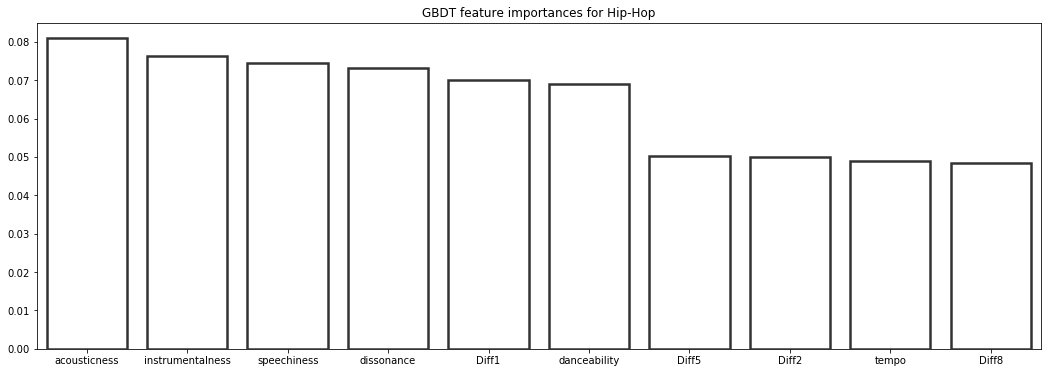

Random Forest: ['danceability', 'valence', 'Diff5', 'Diff1', 'max_diff', 'acousticness', 'Diff8', 'speechiness', 'Diff6', 'Diff7']


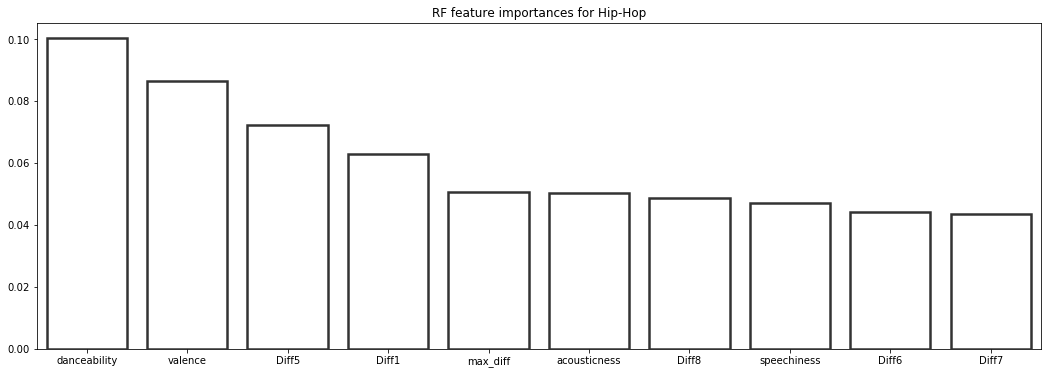

Logistic Regression: ['danceability', 'Diff6', 'instrumentalness', 'E', 'speechiness', 'Diff1', 'Diff10', 'Diff2', 'A', 'Diff8']


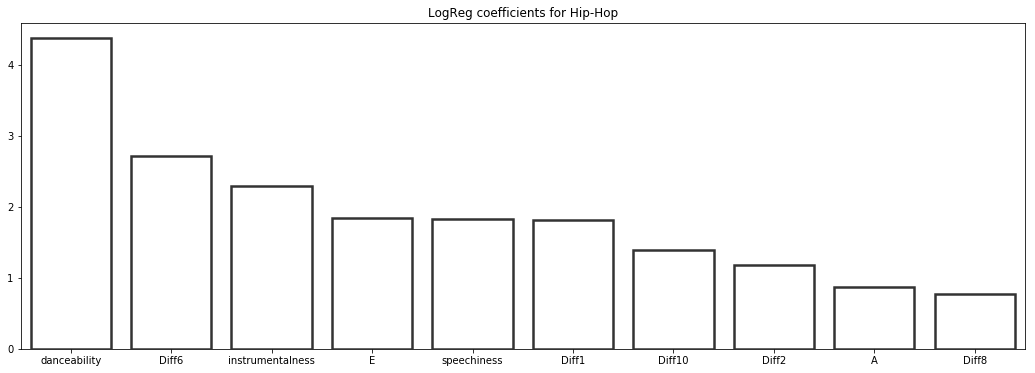

[[156   5]
 [ 19   2]]
Test AUC_ROC: 0.53

Test Scores for 28 tracks from Spotify:
[[14  0]
 [14  0]]
Accuracy: 0.5, AUC_ROC: 0.5

********** Pop **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.12
Number of Tracks for training: 276
Cross Validated Accuracy: 0.83 Precision: 0.10 Recall: 0.07 ROC_AUC: 0.65
Gradient Boosting Tree: ['Diff4', 'dissonance', 'Diff9', 'max_diff', 'valence', 'Diff5', 'instrumentalness', 'tempo', 'liveness', 'Diff2']


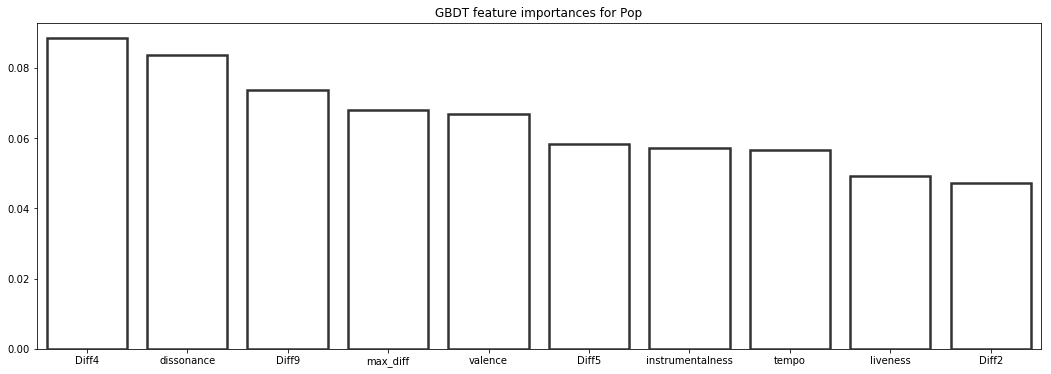

Random Forest: ['track_duration', 'Diff4', 'Diff5', 'Diff10', 'speechiness', 'energy', 'acousticness', 'Diff1', 'Diff6', 'Diff3']


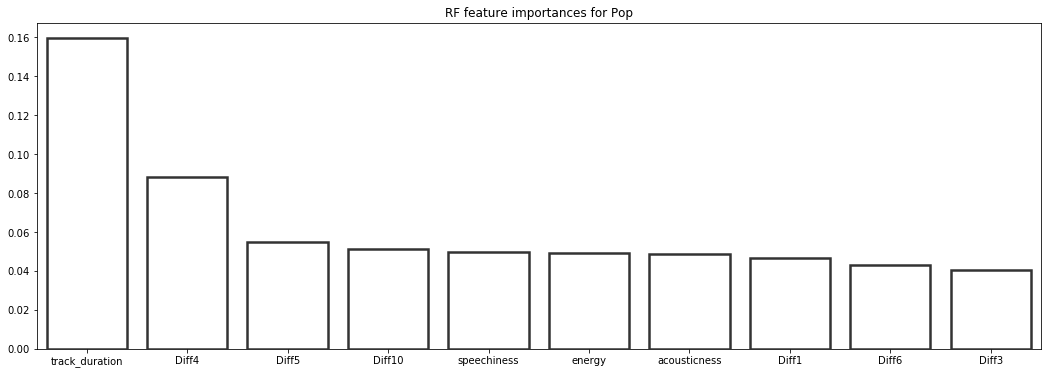

Logistic Regression: ['E', 'F#', 'danceability', 'A#', 'Diff8', 'Diff9', 'D#', 'liveness', 'speechiness', 'Diff10']


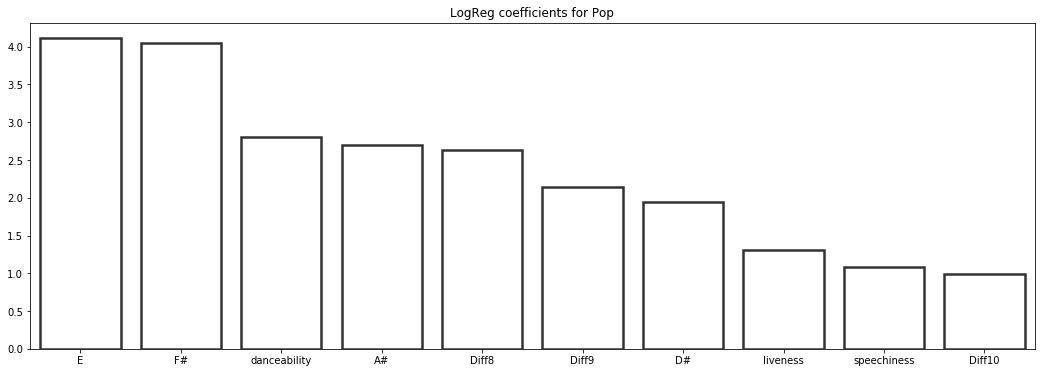

[[63  0]
 [ 7  0]]
Test AUC_ROC: 0.50

********** Rock **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.02
Number of Tracks for training: 3113
Cross Validated Accuracy: 0.88 Precision: 0.15 Recall: 0.04 ROC_AUC: 0.57
Gradient Boosting Tree: ['liveness', 'tempo', 'speechiness', 'Diff2', 'dissonance', 'acousticness', 'Diff7', 'valence', 'Diff5', 'track_duration']


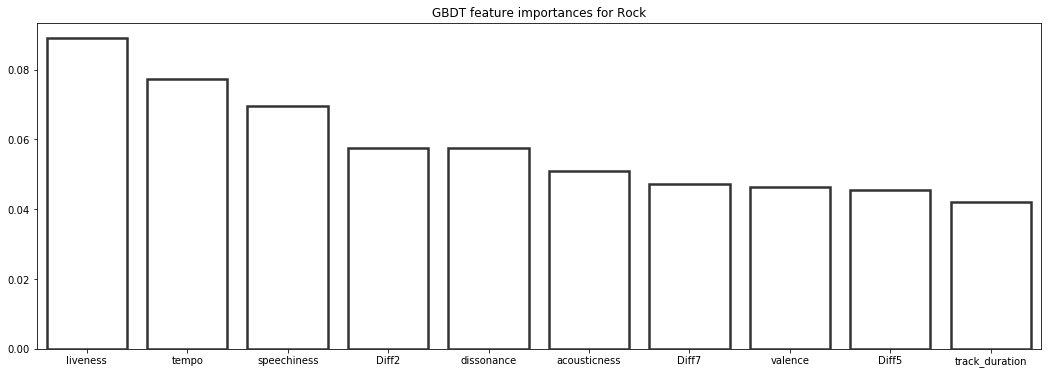

Random Forest: ['Diff1', 'speechiness', 'acousticness', 'energy', 'track_duration', 'tempo', 'Diff6', 'Diff10', 'Diff3', 'Diff8']


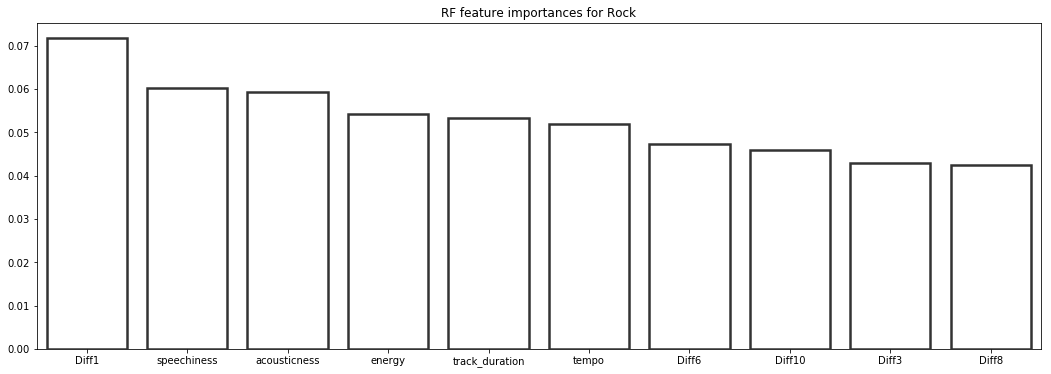

Logistic Regression: ['danceability', 'max_diff', 'energy', 'key_change_freq', 'instrumentalness', 'valence', 'B', 'dissonance', 'liveness', 'C#']


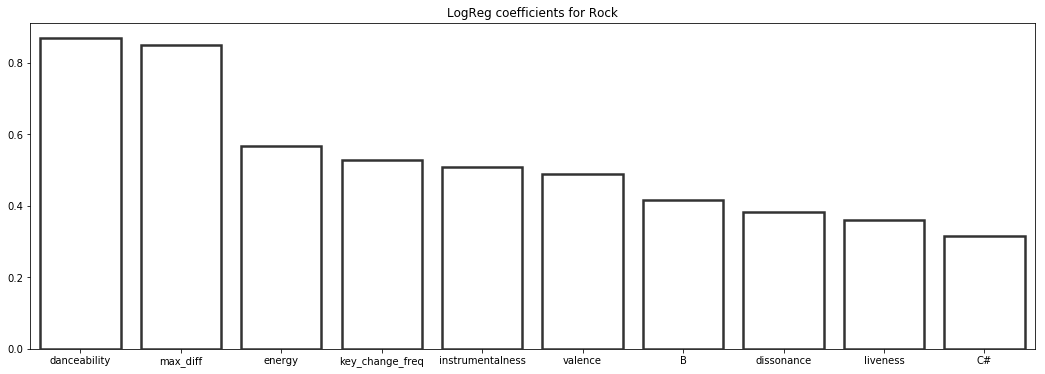

[[668  31]
 [ 76   4]]
Test AUC_ROC: 0.50

Test Scores for 31 tracks from Spotify:
[[18  1]
 [12  0]]
Accuracy: 0.5806451612903226, AUC_ROC: 0.4736842105263158

********** Experimental **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 11.76
Number of Tracks for training: 13

********** Folk **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_ch

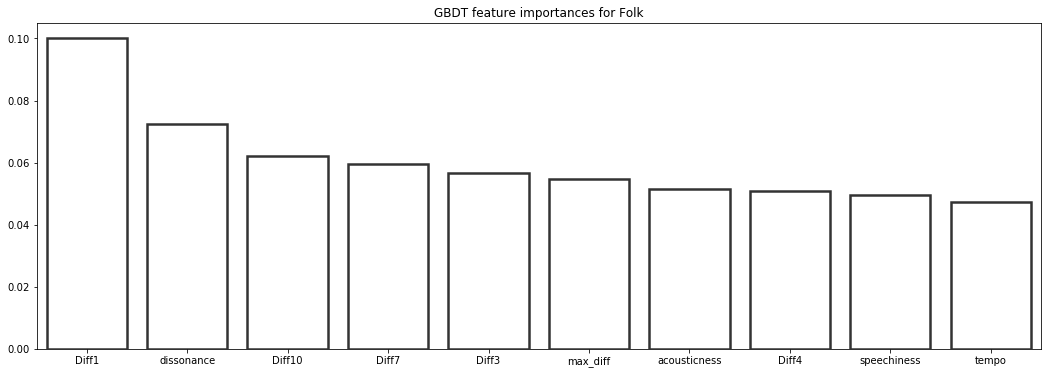

Random Forest: ['acousticness', 'liveness', 'speechiness', 'Diff10', 'track_duration', 'Diff6', 'Diff4', 'Diff3', 'Diff2', 'Diff1']


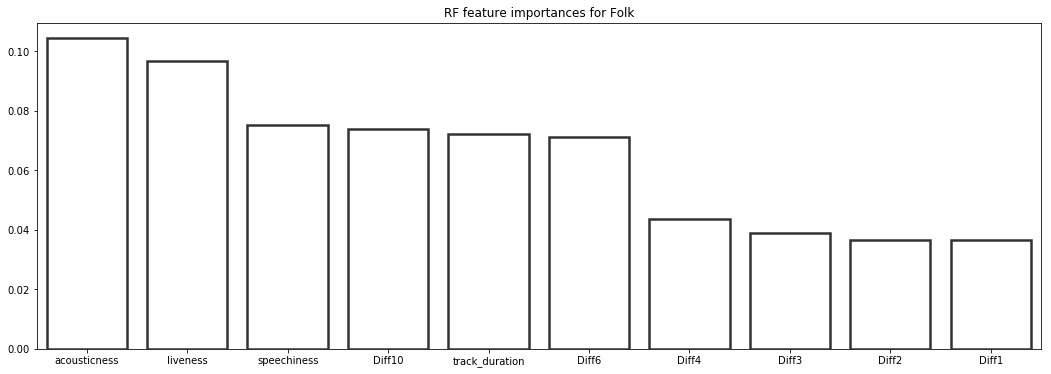

Logistic Regression: ['Diff5', 'Diff10', 'energy', 'acousticness', 'D', 'danceability', 'liveness', 'B', 'G', 'E']


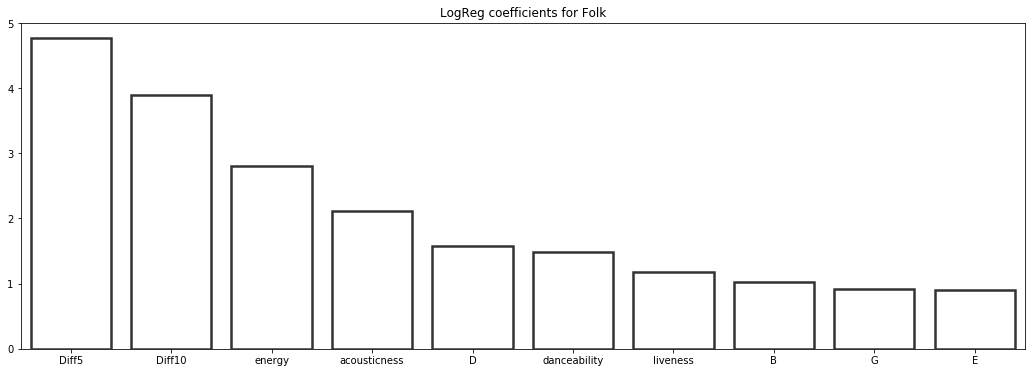

[[146  10]
 [ 19   0]]
Test AUC_ROC: 0.47

********** Jazz **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 9.96
Number of Tracks for training: 192
Cross Validated Accuracy: 0.86 Precision: 0.39 Recall: 0.24 ROC_AUC: 0.74
Gradient Boosting Tree: ['energy', 'tempo', 'Diff5', 'acousticness', 'Diff4', 'Diff7', 'track_duration', 'Diff1', 'valence', 'instrumentalness']


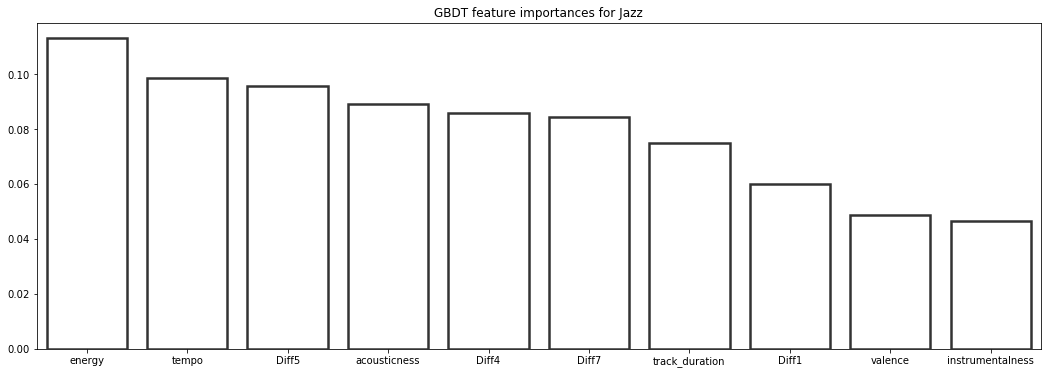

Random Forest: ['instrumentalness', 'max_diff', 'Diff7', 'energy', 'Diff2', 'key_change_freq', 'Diff4', 'dissonance', 'valence', 'C#']


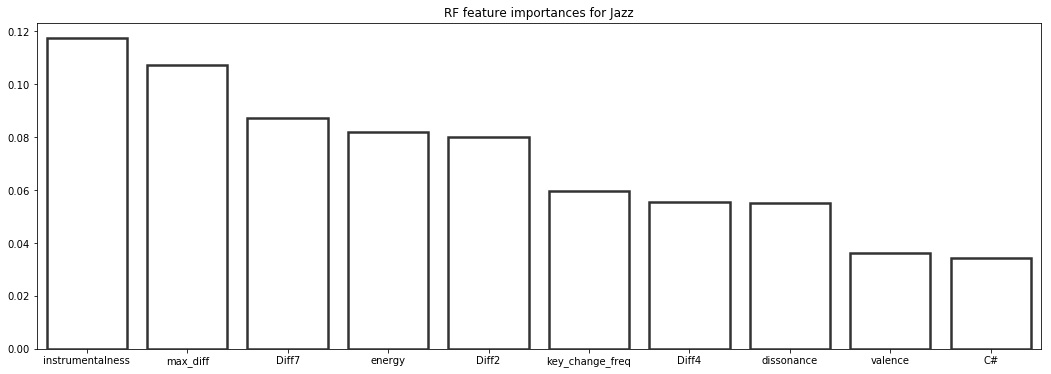

Logistic Regression: ['F', 'energy', 'Diff1', 'valence', 'A', 'Diff4', 'G#', 'A#', 'liveness', 'Diff9']


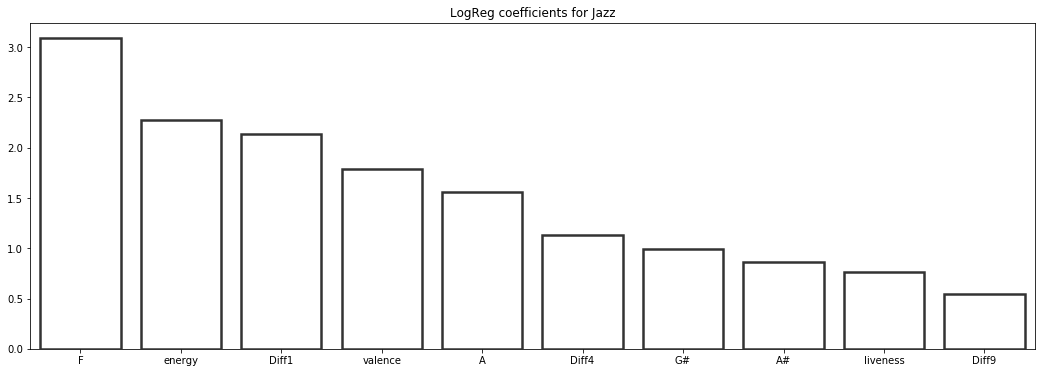

[[45  1]
 [ 2  1]]
Test AUC_ROC: 0.66

********** Electronic **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.00
Number of Tracks for training: 1736
Cross Validated Accuracy: 0.87 Precision: 0.09 Recall: 0.04 ROC_AUC: 0.56
Gradient Boosting Tree: ['valence', 'Diff8', 'Diff10', 'Diff4', 'acousticness', 'speechiness', 'track_duration', 'liveness', 'Diff1', 'Diff9']


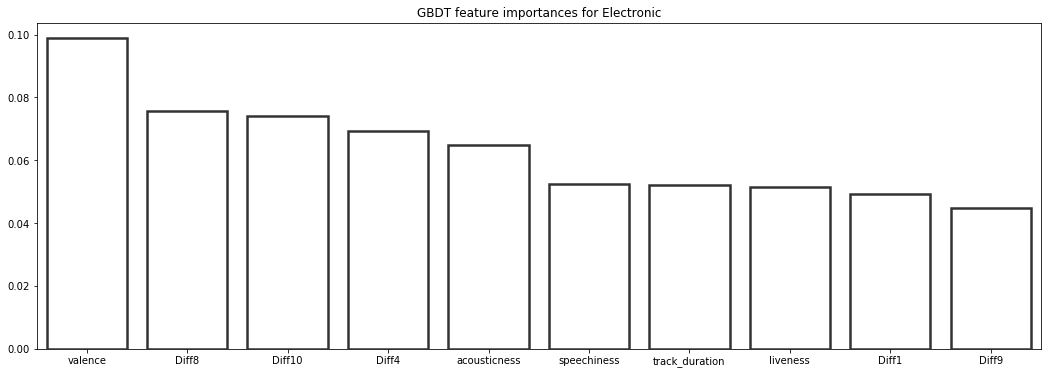

Random Forest: ['energy', 'valence', 'Diff1', 'track_duration', 'acousticness', 'Diff2', 'liveness', 'Diff7', 'max_diff', 'danceability']


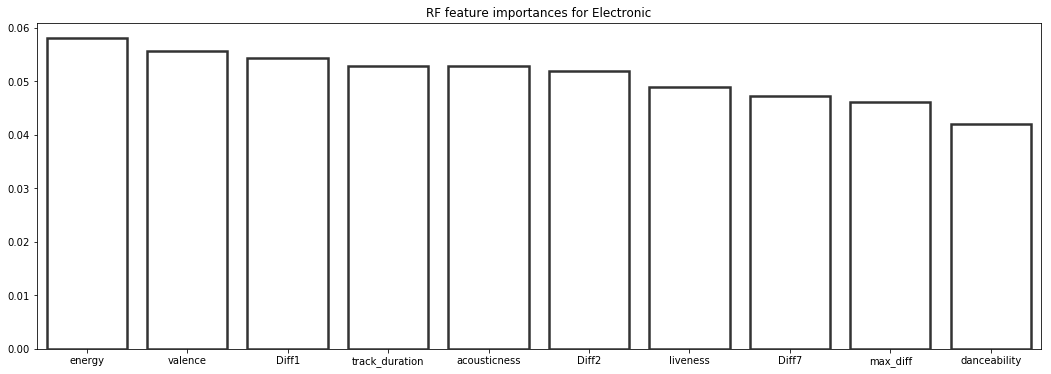

Logistic Regression: ['G#', 'max_diff', 'dissonance', 'danceability', 'Diff1', 'D#', 'energy', 'G', 'A', 'key_change_freq']


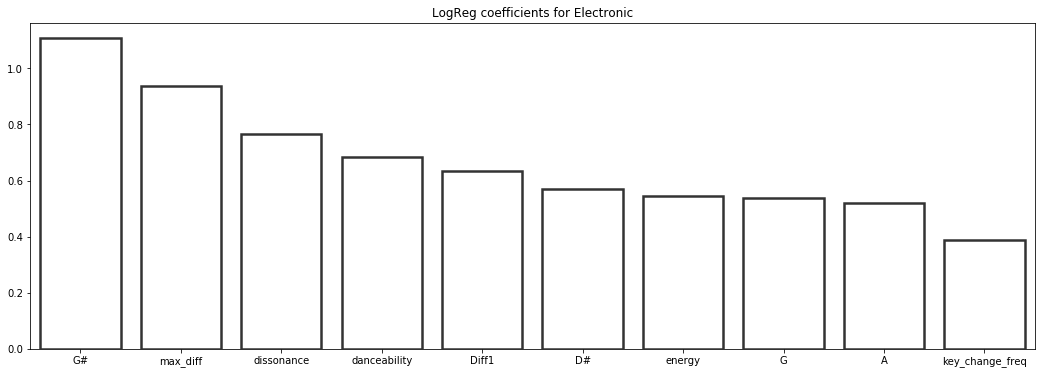

[[370  16]
 [ 45   3]]
Test AUC_ROC: 0.51

Test Scores for 30 tracks from Spotify:
[[19  0]
 [11  0]]
Accuracy: 0.6333333333333333, AUC_ROC: 0.5

********** Spoken **********

********** International **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.53
Number of Tracks for training: 106

********** Soul-RnB **********

********** Blues **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
   

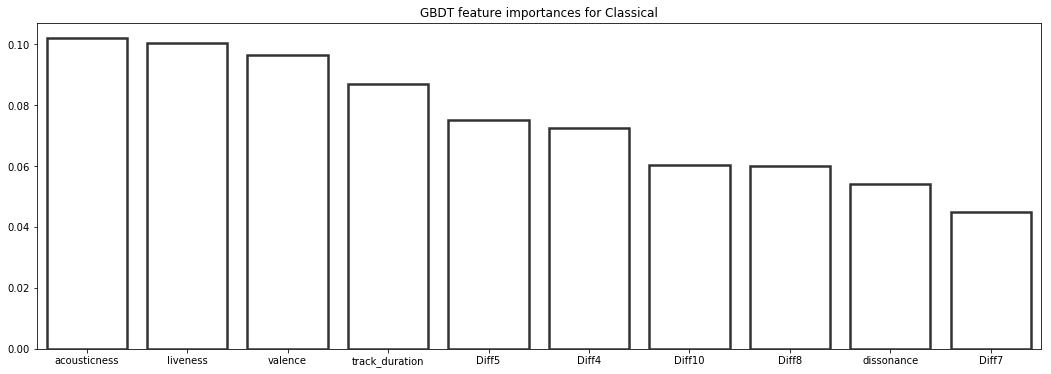

Random Forest: ['track_duration', 'energy', 'instrumentalness', 'liveness', 'Diff9', 'Diff3', 'Diff7', 'Diff4', 'Diff5', 'E']


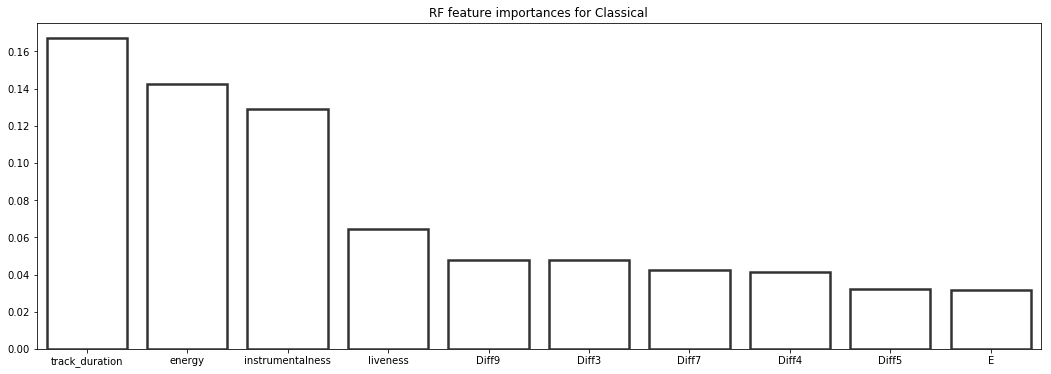

Logistic Regression: ['B', 'key', 'D', 'A', 'F#', 'energy', 'Diff5', 'Diff10', 'Diff4', 'instrumentalness']


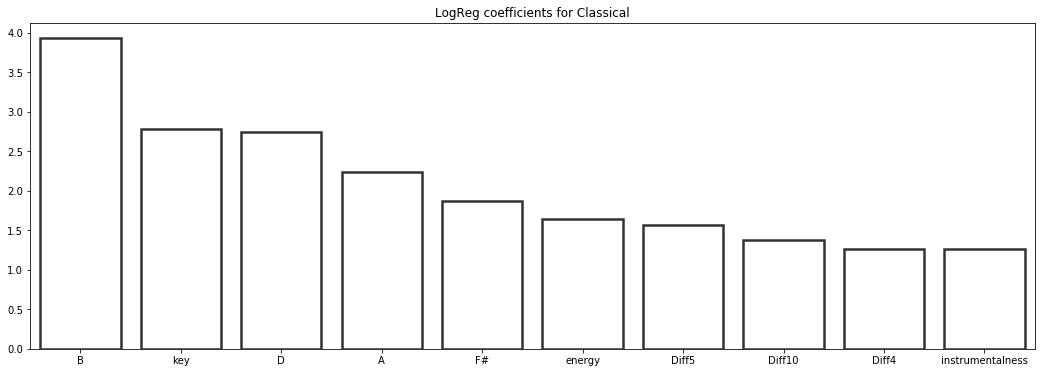

[[44  5]
 [ 4  0]]
Test AUC_ROC: 0.45

********** Old-Time / Historic **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.23
Number of Tracks for training: 281
Cross Validated Accuracy: 0.84 Precision: 0.10 Recall: 0.13 ROC_AUC: 0.59
Gradient Boosting Tree: ['track_duration', 'energy', 'Diff8', 'Diff1', 'Diff10', 'Diff7', 'instrumentalness', 'tempo', 'danceability', 'dissonance']


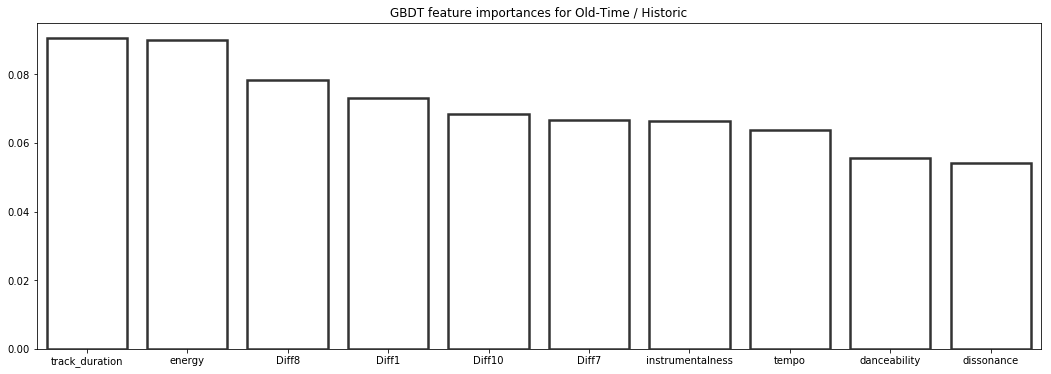

Random Forest: ['Diff4', 'tempo', 'Diff6', 'speechiness', 'danceability', 'Diff3', 'dissonance', 'Diff7', 'Diff5', 'Diff10']


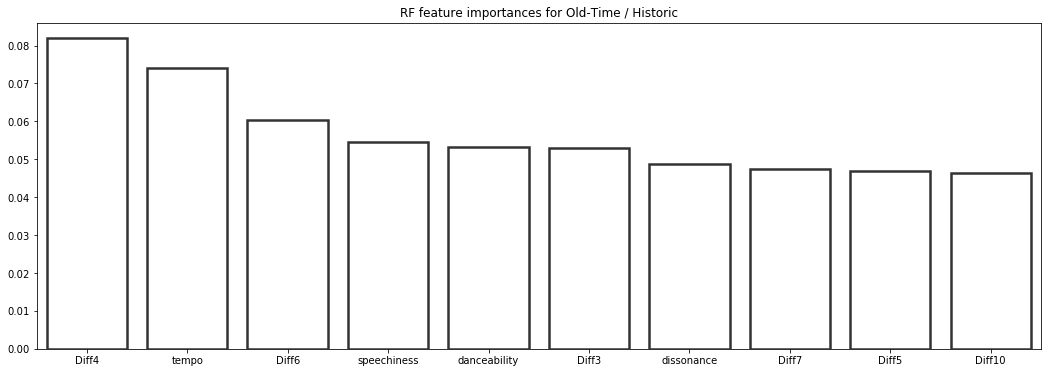

Logistic Regression: ['key', 'Diff4', 'F#', 'liveness', 'Diff9', 'energy', 'G', 'C', 'Diff2', 'A']


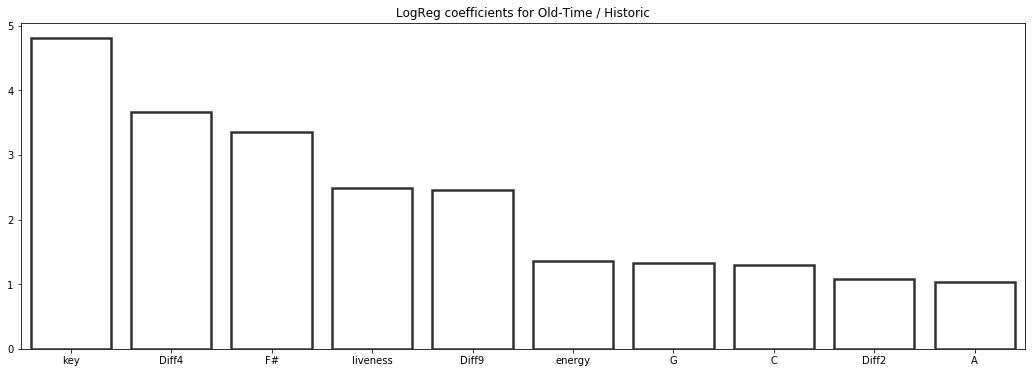

[[62  3]
 [ 4  2]]
Test AUC_ROC: 0.64

********** Instrumental **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Diff8', 'Diff9',
       'Diff10'],
      dtype='object')
% of popular songs: 10.71
Number of Tracks for training: 67

********** Easy Listening **********

********** ALL **********
Features used: Index(['track_duration', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'C',
       'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'key',
       'dissonance', 'max_diff', 'drop_rise', 'key_change_freq', 'Diff1',
       'Diff2', 'Diff3', 'Diff4', 'Diff5', 'Diff6', 'Diff7', 'Di

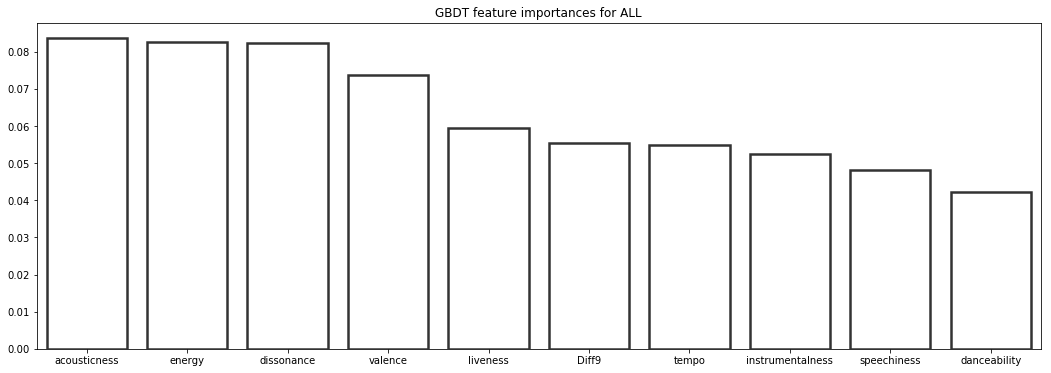

Random Forest: ['speechiness', 'Diff6', 'valence', 'danceability', 'Diff9', 'dissonance', 'Diff10', 'Diff3', 'energy', 'Diff8']


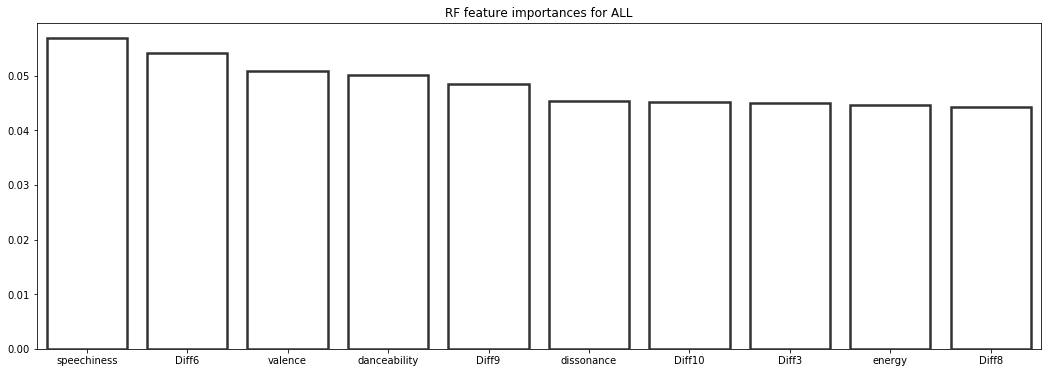

Logistic Regression: ['danceability', 'max_diff', 'F', 'dissonance', 'liveness', 'G#', 'acousticness', 'G', 'F#', 'A#']


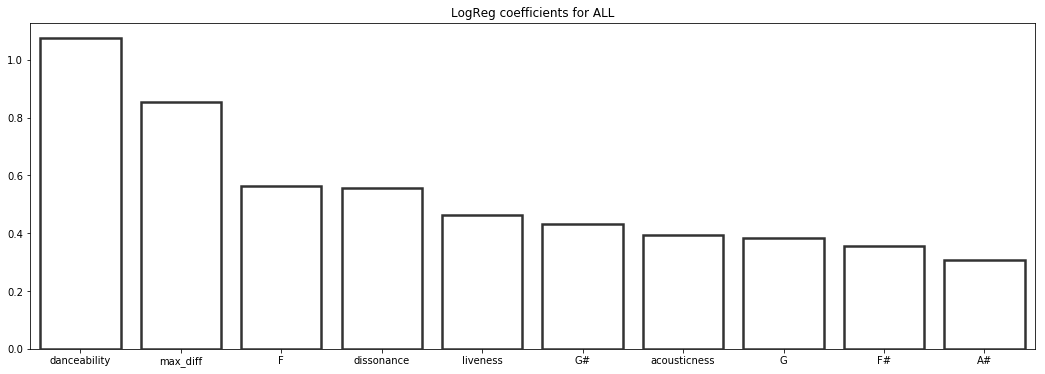

[[1643   54]
 [ 150   23]]
Test AUC_ROC: 0.55



In [44]:
genres = list(tracks.track_genre_top.unique()) + ["ALL"]
models = { 'gbdt': GradientBoostingClassifier(), 
          'rf':RandomForestClassifier(class_weight={0:1, 1:1000}), 
          'lr': LogisticRegression(class_weight={0:1, 1:1000}), 
          "Ensemble": VotingClassifier(estimators=[('gbdt', GradientBoostingClassifier()), ('rf',RandomForestClassifier(class_weight={0:1, 1:1000})), ('lr', LogisticRegression(class_weight={0:1, 1:1000}))], voting='soft')}

scores = {}
for model_name in models.keys():
    print('-'*20 + " " + model_name + " " + '-'*20)
    model = models[model_name]
    auc_scores = get_genre_results(genres, model)
    scores[model_name] = auc_scores
    print()

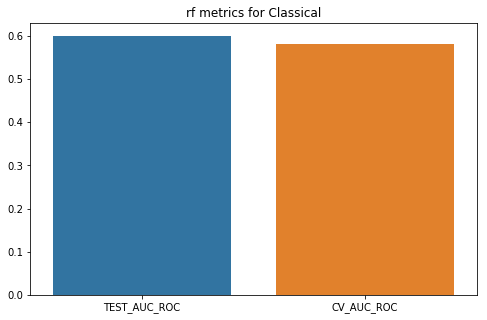

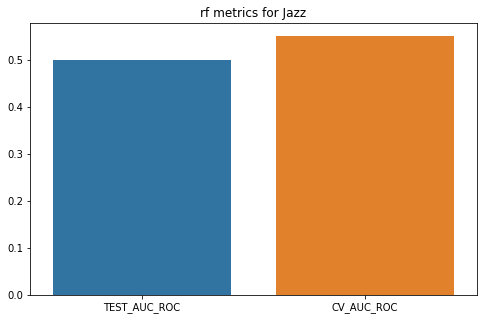

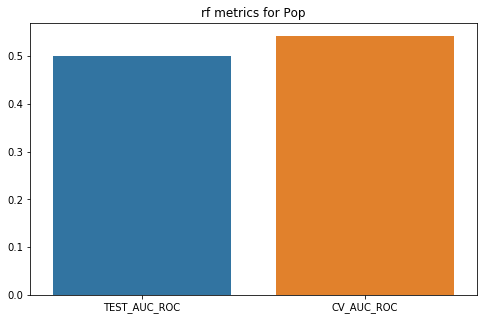

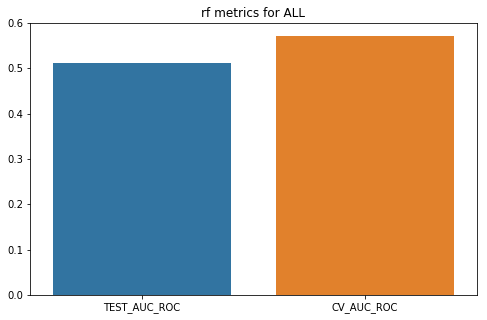

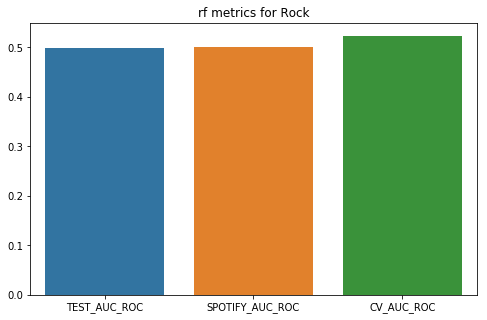

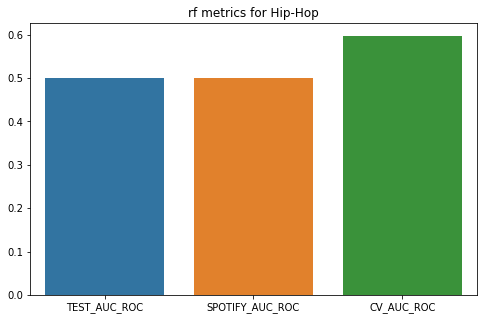

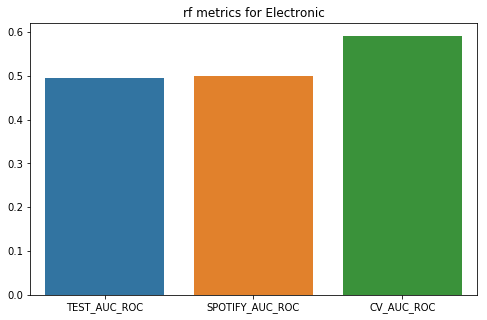

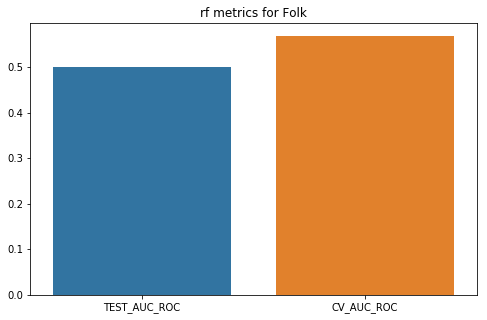

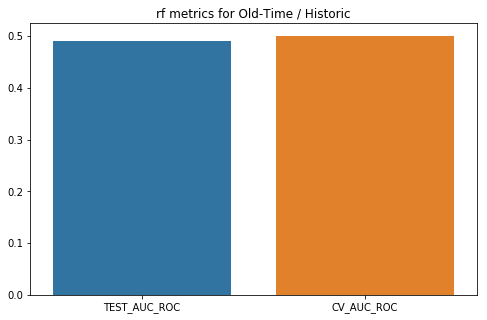

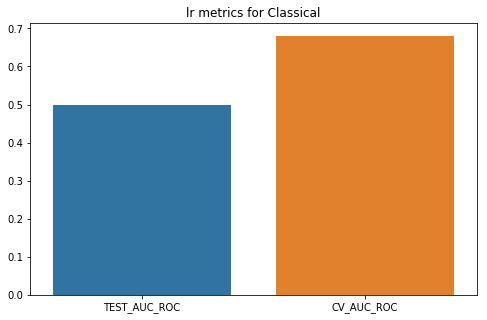

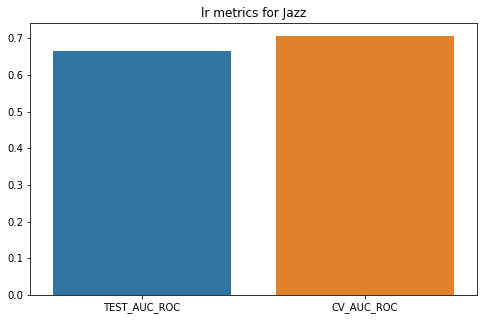

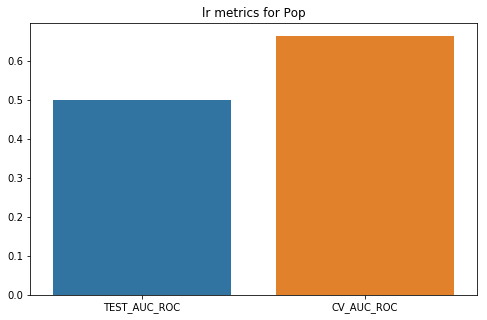

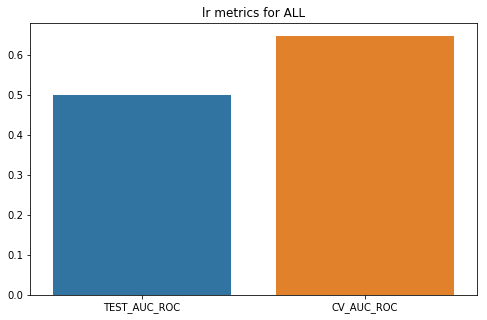

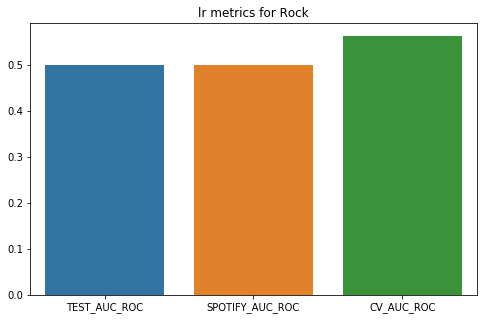

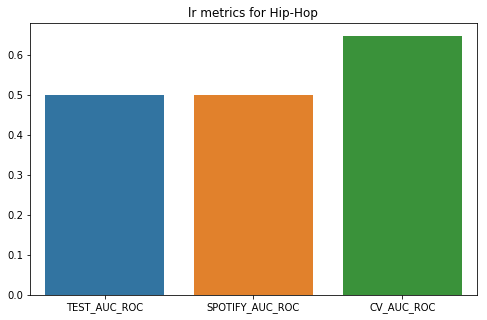

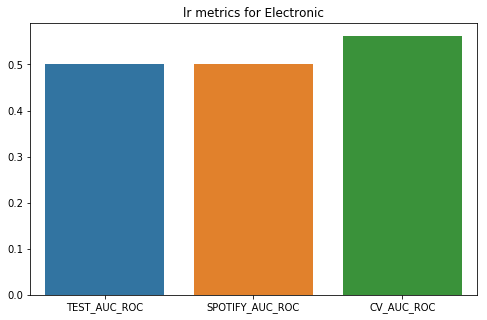

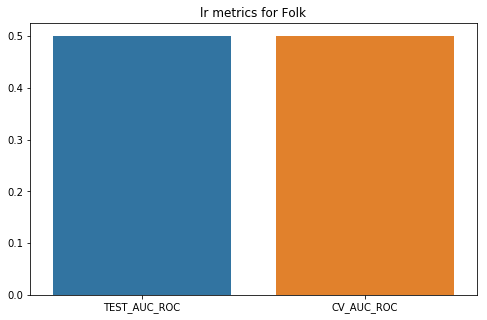

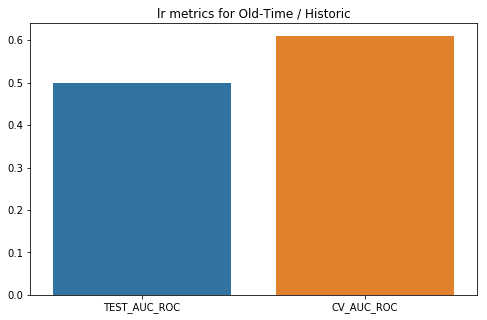

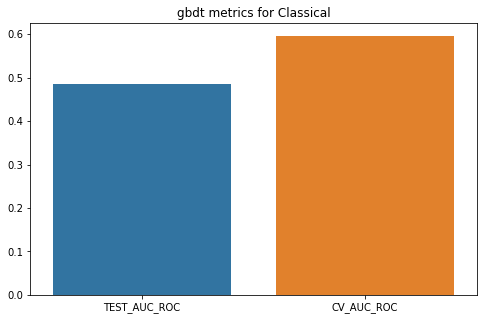

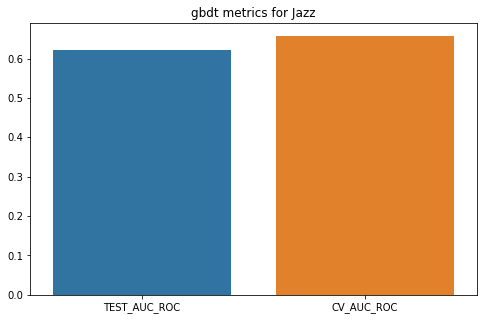

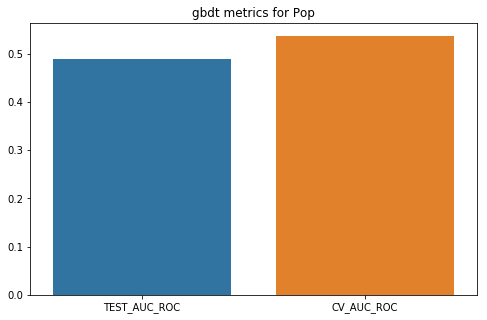

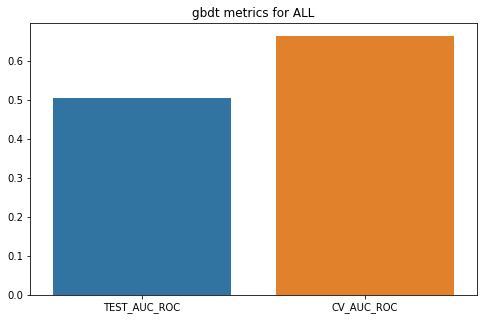

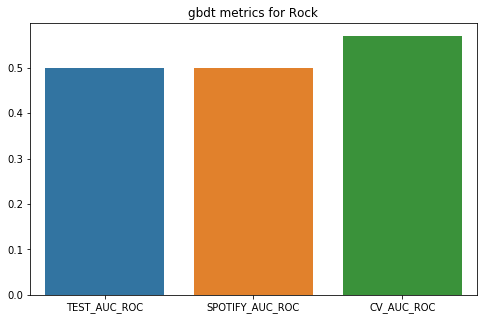

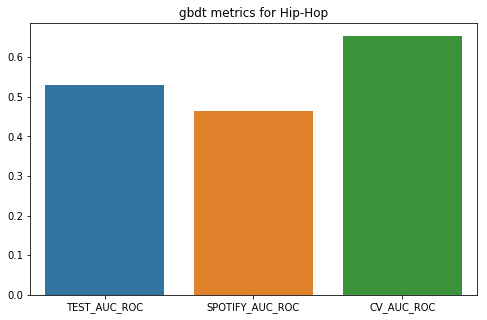

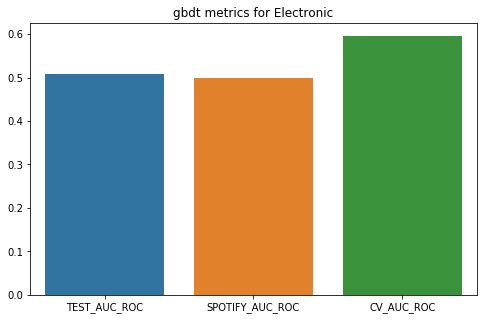

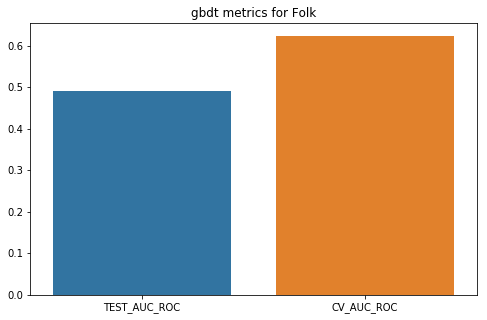

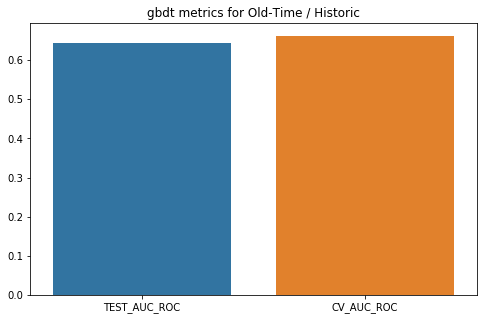

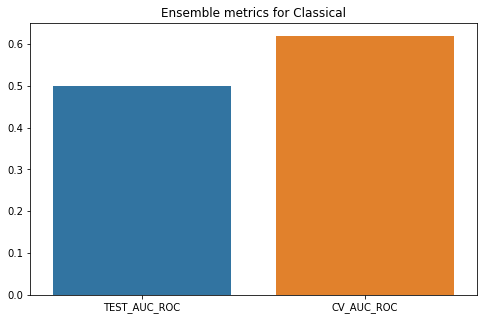

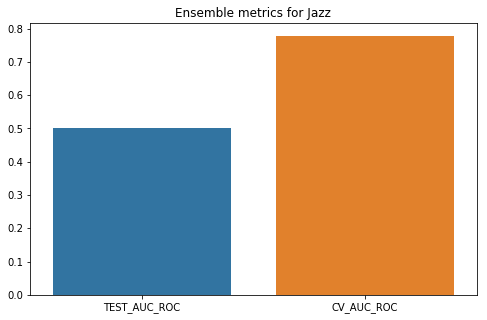

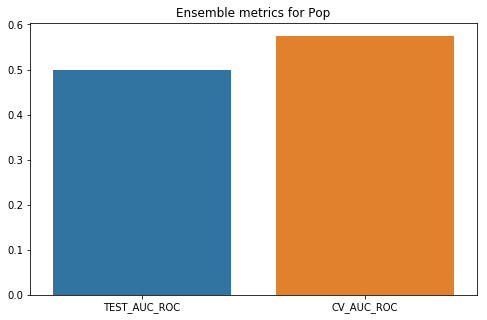

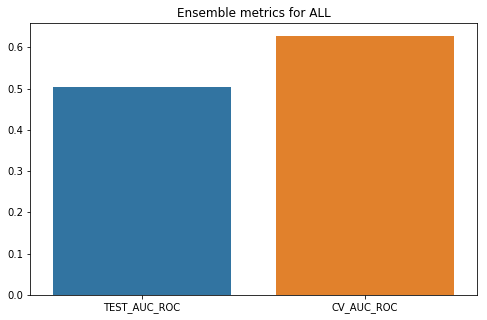

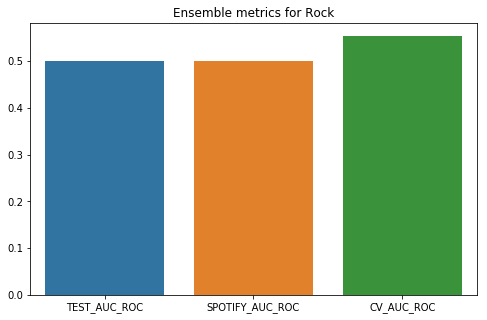

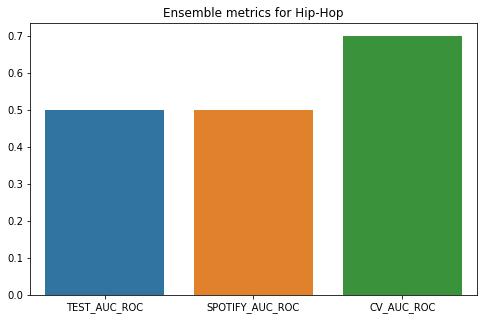

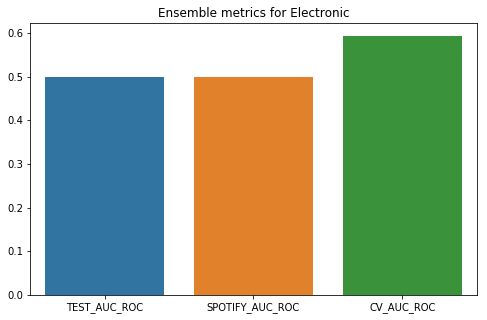

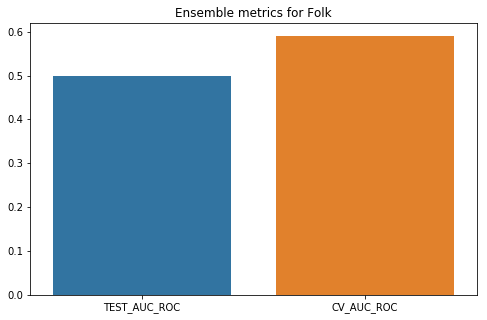

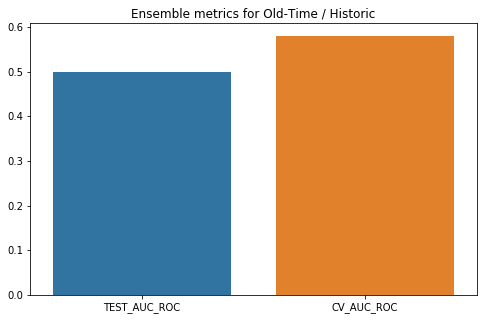

In [27]:
for clf in scores.keys():
    for genre in scores[clf].keys():
        if len(scores[clf][genre].keys()) > 1:
            measures = list(scores[clf][genre].values())
            metric = list(scores[clf][genre].keys())
            
            fig, ax = plt.subplots(figsize=(8, 5))
            ax.set_title('{} metrics for {}'.format(clf, genre))
            sns.barplot(x=metric, y=measures)
            plt.show()